## Bigdata Programming Project
### Module Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
import math
import numpy as np
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

### Data Import

In [2]:
dec = pd.read_excel('Dec.xlsx')
jan = pd.read_excel('Jan.xlsx')
feb = pd.read_excel('Feb.xlsx')
mar = pd.read_excel('Mar.xlsx')
apr = pd.read_excel('Apr.xlsx')
may = pd.read_excel('May.xlsx')
june = pd.read_excel('June.xlsx')
july = pd.read_excel('July.xlsx')
aug = pd.read_excel('Aug.xlsx')
sept = pd.read_excel('Sept.xlsx')
Oct = pd.read_excel('Oct.xlsx')
nov = pd.read_excel('Nov.xlsx')
population = pd.read_excel('population.xlsx')

### Transaction data (building)

In [3]:
Data = pd.DataFrame(pd.concat([dec, jan, feb, mar, apr, may, june, july, aug, sept, Oct, nov], 
                              axis = 0).sort_values(by = ['시군구']).values, 
                    columns = may.columns)

In [4]:
Data['거래유형'].unique() # 거래유형에 따라 가격 차이가 날까?

array(['중개거래', '직거래'], dtype=object)

In [5]:
Data.drop(['계약년월','번지','본번','부번','계약일','해제사유발생일','중개사소재지'], axis = 1, inplace = True)
# 필요 없는 데이터 삭제

In [6]:
Data['거래금액(만원)'] = Data['거래금액(만원)'].str.replace(',', '').astype('int32')
Data = Data.dropna()
Data['건축년도'] = Data['건축년도'].astype('int32')
Data['building_age'] = 2022 - Data['건축년도']
Data['building_age'].unique()

array([25, 17, 21, 23, 30, 13, 20, 19, 35, 16, 31, 37,  5, 27, 34, 41, 43,
       32, 29, 24, 33, 14,  0, 22, 38, 28, 26, 42,  3, 15,  2,  1,  4, 36,
        8, 40,  7,  6, 10, 39, 12,  9, 11, 18, 47, 44, 46, 45, 48, 51, 50,
       60, 49, 52, 53, 55, 61, 54], dtype=int32)

In [7]:
# 정규 표현을 사용해 indexing
import re
info = re.compile(r'\w+ \w+')
region = []
province = []
city = []
for i in Data['시군구'] :
    m = info.search(i)
    region.append(m.group())
    province.append(m.group().split(' ')[0])
    city.append(m.group().split(' ')[1])

In [8]:
Data['region'] = region
Data['province'] = province
Data['city'] = city

### Data Preprocessing

In [9]:
Data.drop('건축년도', axis = 1, inplace = True)
Data['전용면적(㎡)'] = Data['전용면적(㎡)'].astype('float32')

Text(0.5, 1.0, '서울특별시')

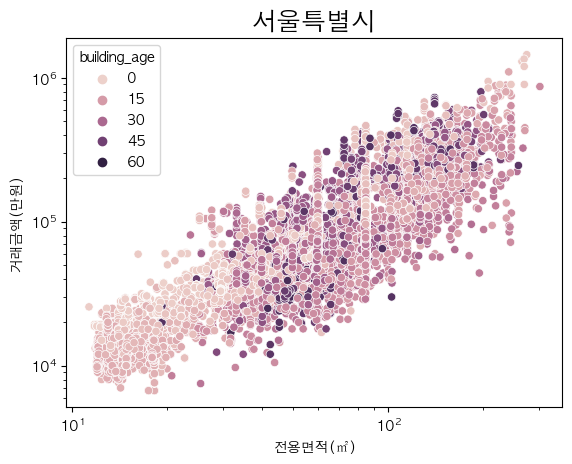

In [10]:
plt.rc('font', family = 'AppleGothic')
sns.scatterplot(data = Data[Data['province'] == '서울특별시'], x = "전용면적(㎡)", y = "거래금액(만원)", hue = "building_age")
plt.yscale('log')
plt.xscale('log')
plt.title('서울특별시', fontsize = 18)

Text(0.5, 1.0, '경기도')

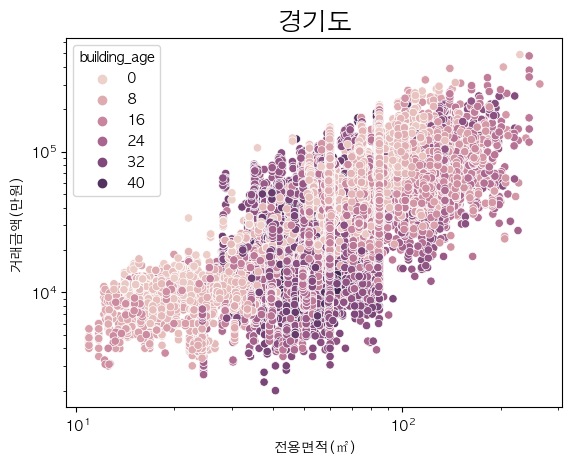

In [11]:
plt.rc('font', family = 'AppleGothic')
sns.scatterplot(data = Data[Data['province'] == '경기도'], x = "전용면적(㎡)", y = "거래금액(만원)", hue = "building_age")
plt.yscale('log')
plt.xscale('log')
plt.title('경기도', fontsize = 18)

전용면적과 가격을 로그화 한다

In [12]:
Data['log_전용면적'] = np.log(Data['전용면적(㎡)'])
Data['log_price'] = np.log(Data['거래금액(만원)'])

Text(0.5, 1.0, '넓이와 가격 사이의 관계')

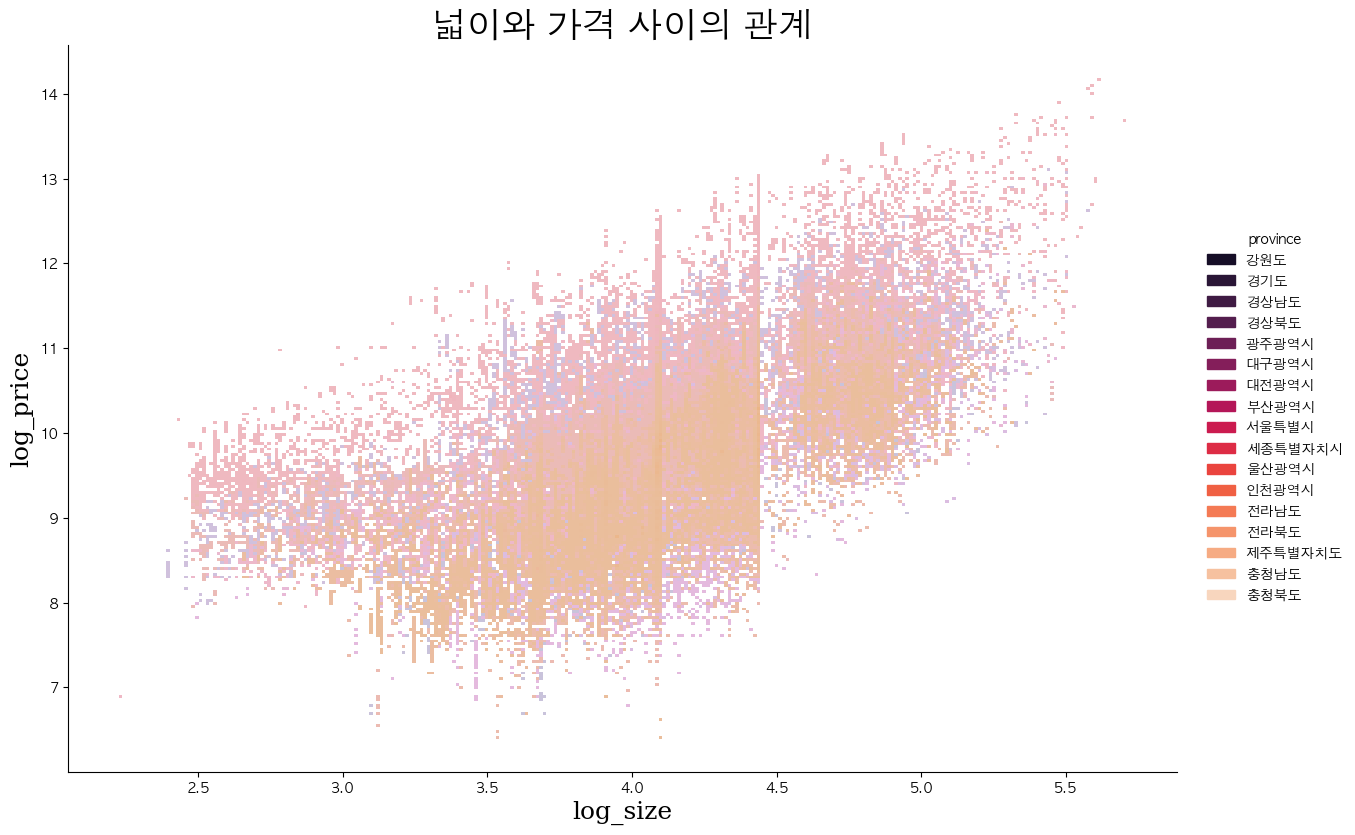

In [13]:
sns.color_palette("rocket", as_cmap=True)
sns.displot(data = Data, x = "log_전용면적", y = "log_price", hue = "province", palette = 'rocket', height = 8, aspect = 1.5)
plt.xlabel('log_size', fontsize = 18, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 18, fontfamily = 'Serif')
plt.title('넓이와 가격 사이의 관계', fontsize = 25, fontweight = 'bold')

#### 지역에 따라 거래금액이 다를까?

Text(0.5, 1.0, 'Size - price with province')

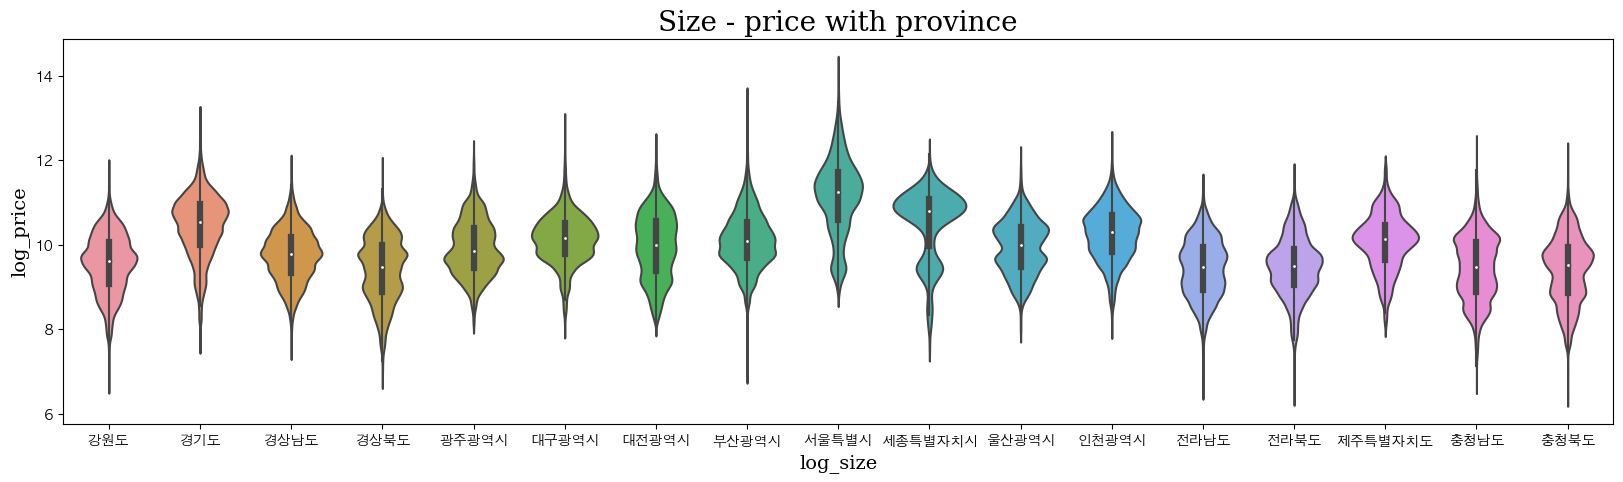

In [14]:
plt.figure(figsize = (20,5))
sns.violinplot(data = Data, x = "province", y = "log_price")
plt.xlabel('log_size', fontsize = 14, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 14, fontfamily = 'Serif')
plt.title('Size - price with province', fontsize = 20, fontfamily = 'Serif')

넓이와 가격 간 상관관계가 존재하며, 지방에 따라 집단적 특성이 발견되었다. 지자체별로 분석하기 위해 province에 대해 one-hot encoding을 진행한다

In [15]:
Data = pd.get_dummies(Data, columns = ['province'])

In [16]:
Data.columns

Index(['시군구', '단지명', '전용면적(㎡)', '거래금액(만원)', '층', '도로명', '거래유형', 'building_age',
       'region', 'city', 'log_전용면적', 'log_price', 'province_강원도',
       'province_경기도', 'province_경상남도', 'province_경상북도', 'province_광주광역시',
       'province_대구광역시', 'province_대전광역시', 'province_부산광역시', 'province_서울특별시',
       'province_세종특별자치시', 'province_울산광역시', 'province_인천광역시', 'province_전라남도',
       'province_전라북도', 'province_제주특별자치도', 'province_충청남도', 'province_충청북도'],
      dtype='object')

#### 건물 연식과 가격간 관계가 있을까?

(7.0, 13.0)

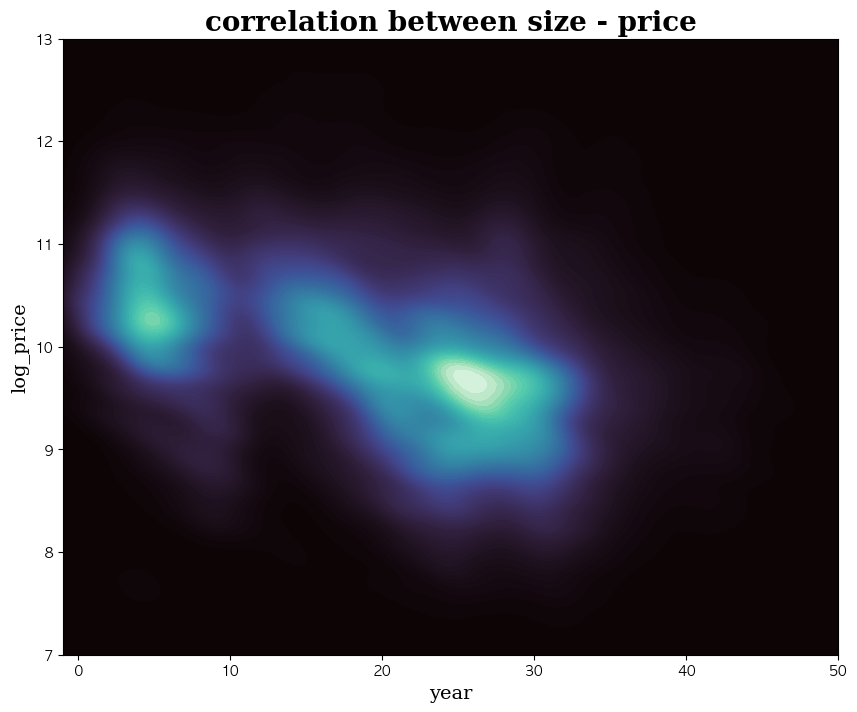

In [17]:
plt.figure(figsize = (10,8))
sns.color_palette("rocket", as_cmap=True)
sns.kdeplot(data = Data, x = "building_age", y = "log_price", palette = 'rocket', 
            fill = True, thresh = 0, levels = 100, cmap = "mako")
plt.xlabel('year', fontsize = 14, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 14, fontfamily = 'Serif')
plt.title('correlation between size - price', fontsize = 20, fontweight = 'bold', fontfamily = 'Serif')
plt.xlim([-1, 50])
plt.ylim([7,13])

In [18]:
Data['building_age'].unique()

array([25, 17, 21, 23, 30, 13, 20, 19, 35, 16, 31, 37,  5, 27, 34, 41, 43,
       32, 29, 24, 33, 14,  0, 22, 38, 28, 26, 42,  3, 15,  2,  1,  4, 36,
        8, 40,  7,  6, 10, 39, 12,  9, 11, 18, 47, 44, 46, 45, 48, 51, 50,
       60, 49, 52, 53, 55, 61, 54], dtype=int32)

건축연도와 아파트 매매가격 간 선형관계가 존재하는 것처럼 보인다. 서수적 특성이 있으므로 건축연도는 건물연식으로 바꾸어 사용한다
- 건물 연식이 클수록 가격은 하락한다

#### 아파트 층수는 가격에 영향을 미칠까?

In [19]:
Data.층 = Data.층.astype(int)

(7.0, 13.0)

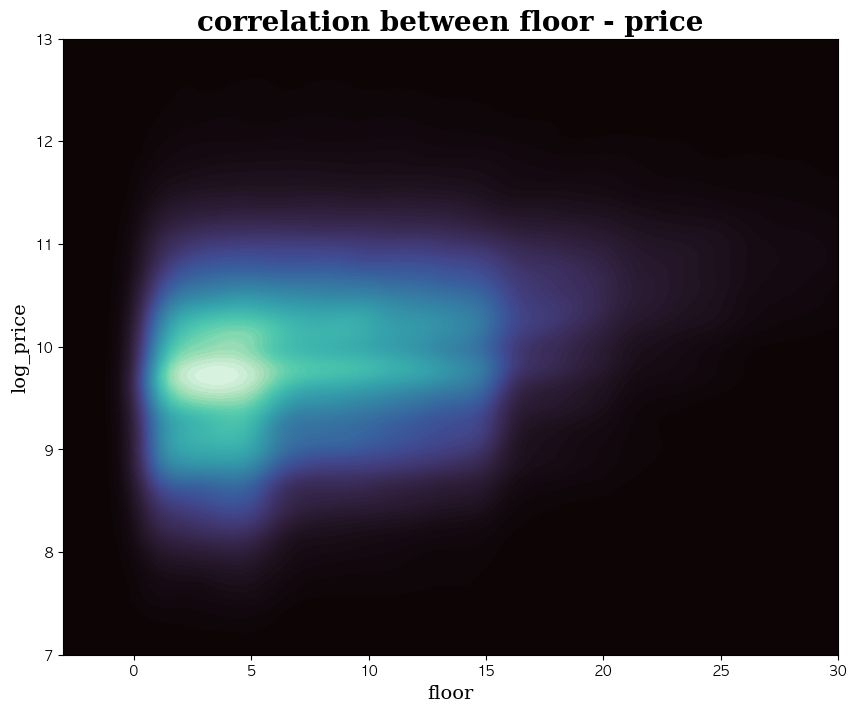

In [20]:
plt.figure(figsize = (10,8))
sns.color_palette("rocket", as_cmap=True)
sns.kdeplot(data = Data, x = "층", y = "log_price", palette = 'rocket', 
            fill = True, thresh = 0, levels = 100, cmap = "mako")
plt.xlabel('floor', fontsize = 14, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 14, fontfamily = 'Serif')
plt.title('correlation between floor - price', fontsize = 20, fontweight = 'bold', fontfamily = 'Serif')
plt.xlim([-3,30])
plt.ylim([7,13])

층수에 따라서 무언가 있는 것 같다. 공분산이 안정적이지 않으므로, 범주형 데이터로 나누기로 한다

In [21]:
def floor(values):
    if values > 20 : return 3
    elif values > 15 : return 2
    elif values > 8 : return 1
    else : return 0

In [22]:
Data['층'] = Data['층'].apply(floor)

범주형 데이터로 나눈 뒤, one hot encoding을 시행한다. 파라미터가 너무 많아도 안좋기 때문이다

Text(0.5, 1.0, 'Floor - price with province')

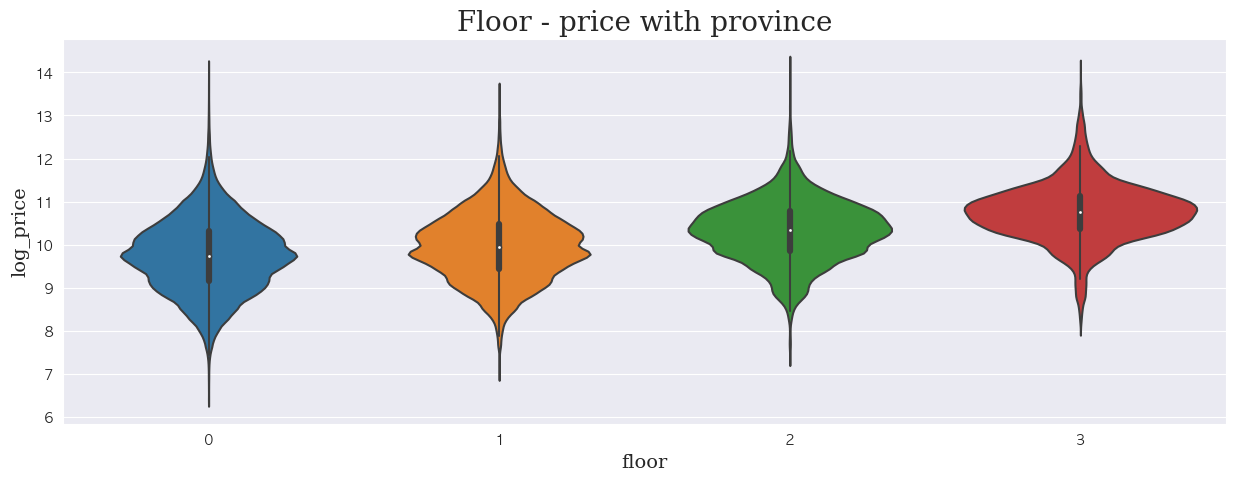

In [23]:
sns.set_style('darkgrid')
plt.rc('font', family = 'AppleGothic')
plt.figure(figsize = (15,5))
sns.violinplot(data = Data, x = "층", y = "log_price")
plt.xlabel('floor', fontsize = 14, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 14, fontfamily = 'Serif')
plt.title('Floor - price with province', fontsize = 20, fontfamily = 'Serif')

In [24]:
Data = pd.get_dummies(Data, columns = ['층'])

#### 거래 유형에 따라서 어떠한 차이가 있을까?

Text(0.5, 1.0, 'Size - price with province')

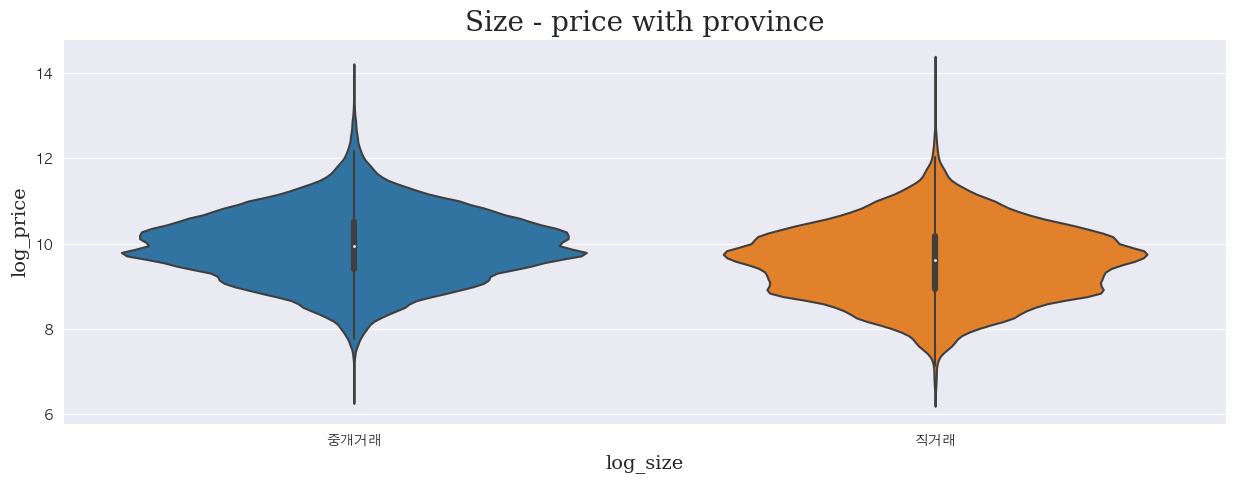

In [25]:
sns.set_style('darkgrid')
plt.rc('font', family = 'AppleGothic')
plt.figure(figsize = (15,5))
sns.violinplot(data = Data, x = "거래유형", y = "log_price")
plt.xlabel('log_size', fontsize = 14, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 14, fontfamily = 'Serif')
plt.title('Size - price with province', fontsize = 20, fontfamily = 'Serif')

직거래의 경우가 평균적으로 가격이 조금 더 낮은 것으로 보인다. one-hot encoding을 진행한다

In [26]:
Data = pd.get_dummies(Data, columns = ['거래유형'])

### population data preprocessing
- 인구와 아파트 매매가격은 유의미한 상관관계가 있지 않을까?

In [27]:
population

,행정기관,총 인구수,연령구간인구수,0세,1세,2세,3세,4세,5세,6세,...,91세,92세,93세,94세,95세,96세,97세,98세,99세,100세 이상
0,서울특별시 종로구,144005,144005,462,482,549,537,600,722,824,...,173,139,122,78,85,50,39,24,26,38
1,서울특별시 중구,122087,122087,547,575,560,555,578,675,675,...,145,141,116,99,59,33,21,25,20,30
2,서울특별시 용산구,222009,222009,1045,1087,1122,1182,1212,1295,1385,...,253,223,203,130,80,68,51,47,38,77
3,서울특별시 성동구,284573,284573,1706,1783,1770,1830,1922,2049,1931,...,229,190,160,98,82,42,35,28,23,51
4,서울특별시 광진구,340396,340396,1310,1353,1405,1512,1551,1803,1984,...,216,188,161,130,80,52,58,36,27,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,경상남도 함양군,38285,38285,93,103,116,148,159,177,181,...,140,88,72,52,47,26,19,12,11,8
246,경상남도 거창군,60756,60756,199,207,265,275,334,351,389,...,164,126,101,67,39,47,25,14,10,25
247,경상남도 합천군,42613,42613,81,106,121,123,116,153,139,...,156,123,83,61,48,30,16,18,16,18
248,제주특별자치도 제주시,493076,493076,2738,3038,3369,3887,4150,4506,5092,...,547,526,326,242,152,121,85,108,137,132


In [28]:
import re
info = re.compile(r'\w+ \w* \w*')
region = []
province = []
city = []
for i in population['행정기관'] :
    m = info.search(i)
    province.append(m.group().split(' ')[0])
    city.append(m.group().split(' ')[1] + m.group().split(' ')[2])

In [29]:
population.index = city

population.drop('행정기관', axis = 1, inplace = True)

for i in range(len(Data.city)) :
    if Data.city.iloc[i][-1] not in ['시','군','구'] :
        Data.city.iloc[i] = '세종시'

#### Make features
- 경제활동인구비율, 유소년/청소년 인구비율, 핵심활동인구비율을 새로 만들어 준다

In [30]:
population['Economic_population'] = population.iloc[:,17:67].sum(axis = 1)/population['총 인구수'] # 경제활동인구비율
population['younger_population'] = population.iloc[:,2:27].sum(axis = 1)/population['총 인구수'] # 유소년/청소년인구비율
population['core_population'] = population.iloc[:,22:48].sum(axis = 1)/population['총 인구수'] # 핵심활동인구비율

#Population Data
Pop_data = population.iloc[:,[0,-3,-2,-1]]
Pop_data.columns = ['Population','economic_population','younger_population','core_population']

#### Data Merging
- population과 Data를 합쳐준다

In [31]:
Data.index = Data['city']
merge_data = pd.merge(Data,Pop_data, left_index=True, right_index=True)

### 인구와 가격간의 관계가 있을까?

Text(0.5, 1.0, 'population - price')

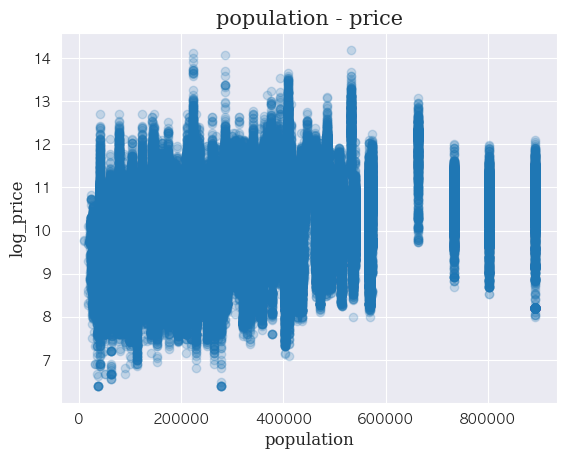

In [32]:
plt.scatter(merge_data["Population"], merge_data["log_price"], alpha = 0.2)
plt.xlabel('population', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 12, fontfamily = 'Serif')
plt.title('population - price', fontsize = 15, fontfamily = 'Serif')

Text(0.5, 1.0, 'economical activity population - price')

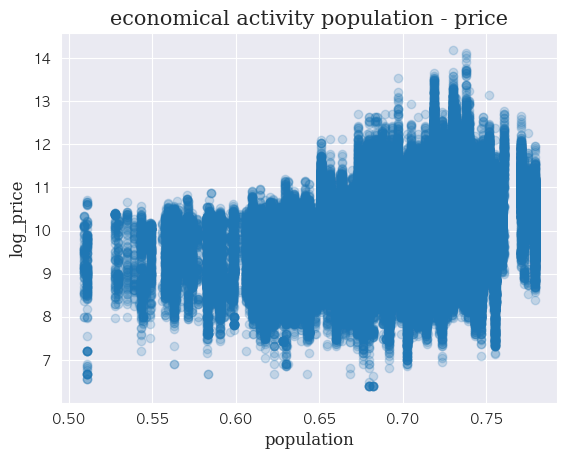

In [33]:
plt.scatter(merge_data["economic_population"], merge_data["log_price"], alpha = 0.2)
plt.xlabel('population', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 12, fontfamily = 'Serif')
plt.title('economical activity population - price', fontsize = 15, fontfamily = 'Serif')

Text(0.5, 1.0, 'core activity population - price')

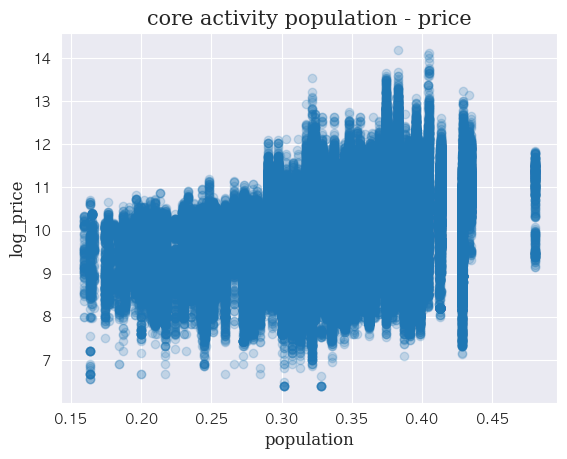

In [34]:
plt.scatter(merge_data["core_population"], merge_data["log_price"], alpha = 0.2)
plt.xlabel('population', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 12, fontfamily = 'Serif')
plt.title('core activity population - price', fontsize = 15, fontfamily = 'Serif')

Text(0.5, 1.0, 'younger population - price')

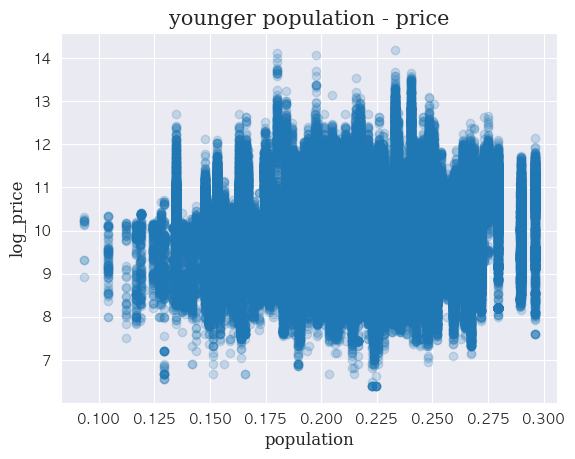

In [35]:
plt.scatter(merge_data["younger_population"], merge_data["log_price"], alpha = 0.2)
plt.xlabel('population', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('log_price', fontsize = 12, fontfamily = 'Serif')
plt.title('younger population - price', fontsize = 15, fontfamily = 'Serif')

경제활동 인구비율과 핵심활동인구의 비율은 높은 상관관계가 있는 것 처럼 보인다

In [36]:
merge_data.iloc[:,-4:].corr()

,Population,economic_population,younger_population,core_population
Population,1.000000,0.625316,0.546636,0.573508
economic_population,0.625316,1.000000,0.632709,0.872456
younger_population,0.546636,0.632709,1.000000,0.627803
core_population,0.573508,0.872456,0.627803,1.000000


상관관계가 높은 변수는 과대 추정을 발생시킬 수 있으므로, core population을 삭제하도록 한다

In [37]:
merge_data.drop('core_population', axis = 1, inplace = True)

## Machine Learning

### Set feature, target

In [38]:
X = merge_data.drop(['시군구','city','단지명','거래금액(만원)','도로명','region','전용면적(㎡)','log_price'], axis = 1)
y = merge_data['log_price']

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

train set R^2 score: 0.7601880287647548
test set R^2 score: 0.7587037902942301
log RMSE: 0.385415840495819
RMSE: 16974.795826945083


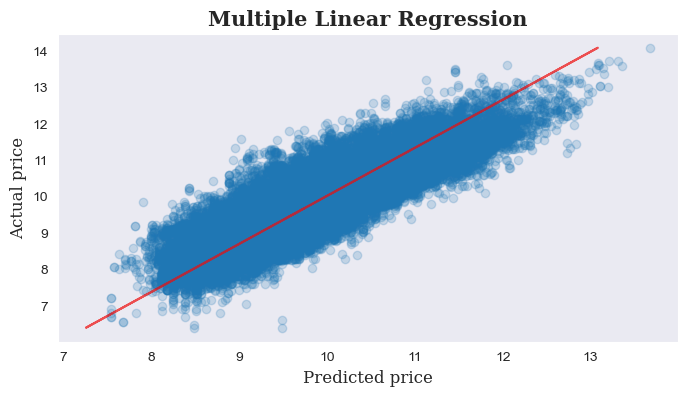

In [42]:
def LR(x,y):
    z=np.polyfit(x,y,1)
    p=np.poly1d(z)
    return p

pred = model.predict(X_test)
score = model.score(X_test, y_test)
mse1 = mean_squared_error(y_test, pred)
rmse1 = math.sqrt(mse1)
mse2 = mean_squared_error(np.exp(y_test), np.exp(pred))
rmse2 = math.sqrt(mse2)
print("train set R^2 score:", model.score(X_train, y_train))
print("test set R^2 score:", model.score(X_test, y_test))
print("log RMSE:", rmse1)
print("RMSE:", rmse2)

sns.set_style('dark')
plt.figure(figsize = (8,4))
plt.scatter(pred, y_test, alpha = 0.2)
pylab.plot(LR(y_test, pred)(y_test), y_test, '-', color = '#ee0c0c', alpha = 0.7)
plt.title("Multiple Linear Regression", fontsize = 15, fontfamily = 'Serif', fontweight = 'bold')
plt.xlabel('Predicted price', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('Actual price', fontsize = 12, fontfamily = 'Serif')
plt.show()

### Random Forest Regression

In [43]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 6, min_samples_split = 3)
model.fit(X_train, y_train)
pred = model.predict(X_test)
score = model.score(X_test, y_test)

train set R^2 score: 0.9666107439967233
test set R^2 score: 0.9514548759508336
log RMSE: 0.17287297967782175
RMSE: 8223.61610808076


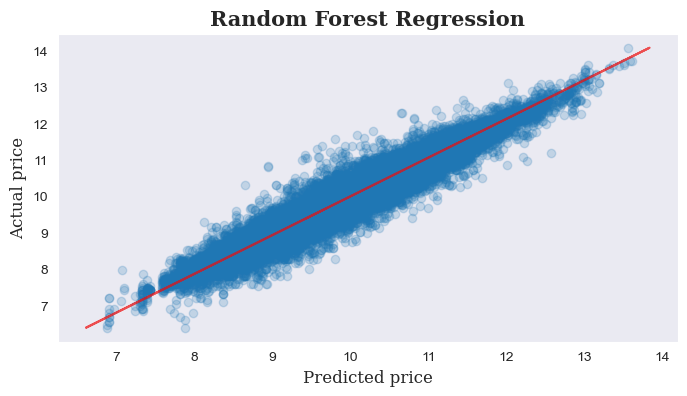

In [44]:
mse1 = mean_squared_error(y_test, pred)
rmse1 = math.sqrt(mse1)
mse2 = mean_squared_error(np.exp(y_test), np.exp(pred))
rmse2 = math.sqrt(mse2)
print("train set R^2 score:", model.score(X_train, y_train))
print("test set R^2 score:", model.score(X_test, y_test))
print("log RMSE:", rmse1)
print("RMSE:", rmse2)


sns.set_style('dark')
plt.figure(figsize = (8,4))
plt.scatter(pred, y_test, alpha = 0.2)
pylab.plot(LR(y_test, pred)(y_test), y_test, '-', color = '#ee0c0c', alpha = 0.7)
plt.title("Random Forest Regression", fontsize = 15, fontfamily = 'Serif', fontweight = 'bold')
plt.xlabel('Predicted price', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('Actual price', fontsize = 12, fontfamily = 'Serif')
plt.show()

### XGBoost Regression

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
import xgboost as xgb

model=xgb.XGBRegressor(
    booster='gbtree',
    max_depth=8,
    min_child_weight=5,
    gamma=0,
    nthread=4,
    colsample_bytree=0.8,
    colsample_bylevel=0.9,
    n_estimators=50,
    random_state=42
    )

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=0.9, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=8, max_leaves=0, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', ...)

train set R^2 score: 0.9074114654703539
test set R^2 score: 0.9027763136186459
log RMSE: 0.24464725771112153
RMSE: 9726.09878412679


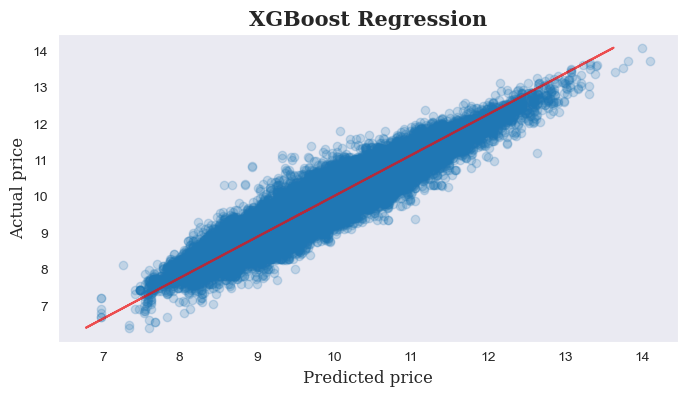

In [47]:
pred = model.predict(X_test)
score = model.score(X_test, y_test)
mse1 = mean_squared_error(y_test, pred)
rmse1 = math.sqrt(mse1)
mse2 = mean_squared_error(np.exp(y_test), np.exp(pred))
rmse2 = math.sqrt(mse2)
print("train set R^2 score:", model.score(X_train, y_train))
print("test set R^2 score:", model.score(X_test, y_test))
print("log RMSE:", rmse1)
print("RMSE:", rmse2)

sns.set_style('dark')
plt.figure(figsize = (8,4))
plt.scatter(pred, y_test, alpha = 0.2)
pylab.plot(LR(y_test, pred)(y_test), y_test, '-', color = '#ee0c0c', alpha = 0.7)
plt.title("XGBoost Regression", fontsize = 15, fontfamily = 'Serif', fontweight = 'bold')
plt.xlabel('Predicted price', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('Actual price', fontsize = 12, fontfamily = 'Serif')
plt.show()

### Gradient Boost Regression

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1)
model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=300)

train set R^2 score: 0.8580984414373882
test set R^2 score: 0.857483932940617
log RMSE: 0.29620079817653877
RMSE: 12440.066651916966


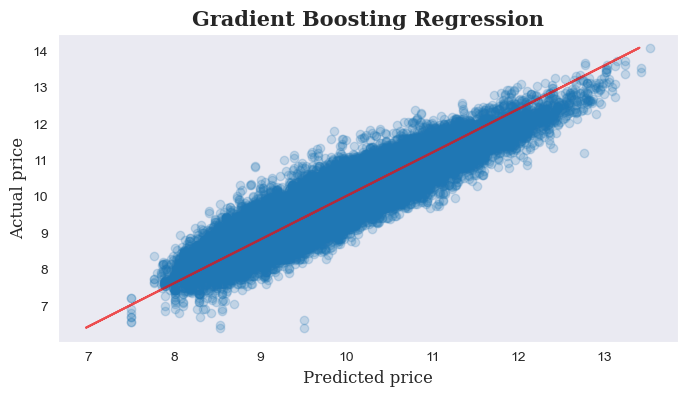

In [49]:
pred = model.predict(X_test)
score = model.score(X_test, y_test)
mse1 = mean_squared_error(y_test, pred)
rmse1 = math.sqrt(mse1)
mse2 = mean_squared_error(np.exp(y_test), np.exp(pred))
rmse2 = math.sqrt(mse2)
print("train set R^2 score:", model.score(X_train, y_train))
print("test set R^2 score:", model.score(X_test, y_test))
print("log RMSE:", rmse1)
print("RMSE:", rmse2)

sns.set_style('dark')
plt.figure(figsize = (8,4))
plt.scatter(pred, y_test, alpha = 0.2)
pylab.plot(LR(y_test, pred)(y_test), y_test, '-', color = '#ee0c0c', alpha = 0.7)
plt.title("Gradient Boosting Regression", fontsize = 15, fontfamily = 'Serif', fontweight = 'bold')
plt.xlabel('Predicted price', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('Actual price', fontsize = 12, fontfamily = 'Serif')
plt.show()

### Light GBM Regression

In [50]:
import lightgbm as lgb
import os

model = lgb.LGBMRegressor(num_leaves=100, min_child_samples=15, max_depth=20, learning_rate=0.1, reg_alpha=0.05)
model.fit(X_train, y_train)

LGBMRegressor(max_depth=20, min_child_samples=15, num_leaves=100,
              reg_alpha=0.05)

train set R^2 score: 0.8994869170598464
test set R^2 score: 0.896376678437703
log RMSE: 0.25257075626113484
RMSE: 10682.771135064937


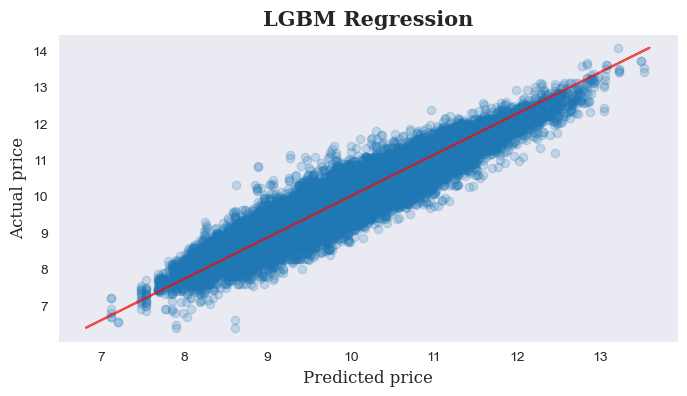

In [51]:
pred = model.predict(X_test)
score = model.score(X_test, y_test)
mse1 = mean_squared_error(y_test, pred)
rmse1 = math.sqrt(mse1)
mse2 = mean_squared_error(np.exp(y_test), np.exp(pred))
rmse2 = math.sqrt(mse2)
print("train set R^2 score:", model.score(X_train, y_train))
print("test set R^2 score:", model.score(X_test, y_test))
print("log RMSE:", rmse1)
print("RMSE:", rmse2)

sns.set_style('dark')
plt.figure(figsize = (8,4))
plt.scatter(pred, y_test, alpha = 0.2)
pylab.plot(LR(y_test, pred)(y_test), y_test, '-', color = '#ee0c0c', alpha = 0.7)
plt.title("LGBM Regression", fontsize = 15, fontfamily = 'Serif', fontweight = 'bold')
plt.xlabel('Predicted price', fontsize = 12, fontfamily = 'Serif')
plt.ylabel('Actual price', fontsize = 12, fontfamily = 'Serif')
plt.show()

Random Forest Regressor의 모형이 test data에 대해 가장 좋으므로 최종 모델로 선정한다

In [52]:
model = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 6, min_samples_split = 3)
model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=6, min_samples_split=3)

## client search

### Data Searching

In [53]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406733 entries, 가평군 to 횡성군
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   building_age         406733 non-null  int32  
 1   log_전용면적             406733 non-null  float32
 2   province_강원도         406733 non-null  uint8  
 3   province_경기도         406733 non-null  uint8  
 4   province_경상남도        406733 non-null  uint8  
 5   province_경상북도        406733 non-null  uint8  
 6   province_광주광역시       406733 non-null  uint8  
 7   province_대구광역시       406733 non-null  uint8  
 8   province_대전광역시       406733 non-null  uint8  
 9   province_부산광역시       406733 non-null  uint8  
 10  province_서울특별시       406733 non-null  uint8  
 11  province_세종특별자치시     406733 non-null  uint8  
 12  province_울산광역시       406733 non-null  uint8  
 13  province_인천광역시       406733 non-null  uint8  
 14  province_전라남도        406733 non-null  uint8  
 15  province_전라북도        40

#### client's data (condition)

In [54]:
ba = 10 # 연식
size = np.log(84) # 전용면적
floor = 16
reg = '서울특별시'
trac = '중개거래'
client1 = [ba, size, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]

In [55]:
client2 = 60000 # 가격으로 검색

#### Prediction

In [56]:
cpred1 = model.predict([client1])
cpred1

array([11.88655913])

In [57]:
y.loc[(y.values>(cpred1.round(3)-0.002)) & (y.values<(cpred1.round(3)+0.002))].index.unique()

Index(['고양일산동구', '서초구', '성동구'], dtype='object')

In [58]:
cpred2 = np.log(client2)
y.loc[(y.values>(cpred2.round(3)-0.001)) & (y.values<(cpred2.round(3)+0.001))].index.unique()

Index(['강남구', '강동구', '강릉시', '강북구', '강서구', '경산시', '계양구', '고양덕양구', '고양일산동구',
       '고양일산서구',
       ...
       '청주청원구', '청주흥덕구', '춘천시', '충주시', '파주시', '평택시', '포항남구', '하남시', '해운대구',
       '화성시'],
      dtype='object', length=106)

#### Backpropagation

In [59]:
Data.index = range(len(Data.index))

In [60]:
res = pd.DataFrame()
for k in np.array(y.loc[(y.values>(cpred1.round(3)-0.002)) & (y.values<(cpred1.round(3)+0.002))].index.unique()) : 
    res = pd.concat([res, Data[Data['city'] == k]])

### result filtering

In [61]:
result = res.loc[((res['log_price'] - cpred1)**2).sort_values()[:50].index][['단지명','전용면적(㎡)','도로명','building_age','거래금액(만원)','거래유형_중개거래','region']]
result = result[result['building_age'] < (ba + ba/2)]
result = result[result['전용면적(㎡)'] < (np.exp(size) + np.exp(size/2))]
result = result[result['전용면적(㎡)'] > (np.exp(size) - np.exp(size/2))]
result

,단지명,전용면적(㎡),도로명,building_age,거래금액(만원),거래유형_중개거래,region
18652,킨텍스원시티2블럭,84.653999,월드고양로 19,3,145500,1,경기도 고양일산동구
176819,두산위브,84.989998,행당로8길 8,13,145000,1,서울특별시 성동구
18717,킨텍스원시티1블럭,84.504303,태극로 8,3,145000,1,경기도 고양일산동구
176374,서초네이처힐3단지,84.769997,태봉로2길 60,9,145000,1,서울특별시 서초구
176657,대명루첸,84.949997,뚝섬로 436,13,146500,1,서울특별시 성동구
176587,텐즈힐(2구역),84.919998,마장로 137,8,148000,1,서울특별시 성동구
18653,킨텍스원시티3블럭,84.653999,월드고양로 21,3,150000,1,경기도 고양일산동구


In [62]:
result = res.loc[((res['log_price'] - cpred2)**2).sort_values()[:50].index][['단지명','전용면적(㎡)','도로명','building_age','거래금액(만원)','거래유형_중개거래','region']]
#result = result[result['building_age'] < (ba + ba/2)]
#result = result[result['전용면적(㎡)'] < (np.exp(size) + np.exp(size/2))]
#result = result[result['전용면적(㎡)'] > (np.exp(size) - np.exp(size/2))]
result

,단지명,전용면적(㎡),도로명,building_age,거래금액(만원),거래유형_중개거래,region
19016,숲속마을9단지(성원),100.550003,숲속마을로 195,16,60000,1,경기도 고양일산동구
18452,흰돌마을(한진),84.690002,백석로 26,28,60000,1,경기도 고양일산동구
18956,하늘마을주공5단지,84.669998,하늘마을1로 25,15,60000,1,경기도 고양일산동구
18658,호수마을(삼환),132.330002,노루목로 80,28,60000,0,경기도 고양일산동구
18335,흰돌마을(한진),69.089996,백석로 26,28,60000,1,경기도 고양일산동구
18679,호수마을(청구),67.735001,노루목로 99,28,60000,1,경기도 고양일산동구
176273,대림서초리시온,45.099998,서초중앙로22길 25,19,60000,1,서울특별시 서초구
18708,호수마을(청구),67.735001,노루목로 99,28,60000,1,경기도 고양일산동구
18878,일산센트럴아이파크,84.985397,중산로 70,4,60000,1,경기도 고양일산동구
18629,SKVIEW,84.319801,은행마을로 100,19,60000,1,경기도 고양일산동구


## Map Visualization

### json, folium import

In [63]:
import json, folium

code = pd.read_excel('code.xlsx')
for i in range(len(code)) : code.행정기관코드.iloc[i] = str(code.행정기관코드.iloc[i])[:5]
    
mean_price = Data[['거래금액(만원)','region']].groupby(['region'], as_index=False).mean()

for i in range(len(mean_price.region)) :
    if mean_price.region.iloc[i][-1] not in ['시','군','구'] :
        mean_price.region.iloc[i] = '세종시'
        
mean_price = mean_price.groupby(['region'], as_index=False).mean()

code = pd.concat([code, mean_price['거래금액(만원)']], axis = 1)

Mapping = folium.Map([37.5, 127], zoom_start=9)

cp = folium.Choropleth(
    geo_data='./border.json',
    data=code, 
    columns=['행정기관코드', '거래금액(만원)'], 
    key_on='feature.properties.SIG_CD', 
    fill_color='Greens',
    fill_opacity=0.66, 
    line_opacity=1,
    legend_name='지역별 평균 거래가격'
).add_to(Mapping)

code_indexed = code.set_index('행정기관코드')

for s in cp.geojson.data['features']:
    if s['properties']['SIG_CD'] in code.행정기관코드.unique():
        s['properties']['mean_price'] = code_indexed.loc[s['properties']['SIG_CD'], '거래금액(만원)']
    else:
        s['properties']['mean_price'] = 0

    s['properties']['Region'] = s['properties']['SIG_KOR_NM']

folium.GeoJsonTooltip(['Region', 'mean_price']).add_to(cp.geojson)

In [64]:
Mapping

In [65]:
Mapping.save(r'./mean_price.html')

## Save Model and Data

In [67]:
import pickle
import gzip

# save and compress.
with gzip.open('model.pickle', 'wb') as f : pickle.dump(model, f)
    
with gzip.open('X.pickle', 'wb') as f : pickle.dump(X, f)
    
with gzip.open('y.pickle', 'wb') as f : pickle.dump(y, f)
    
with gzip.open('Data.pickle', 'wb') as f : pickle.dump(Data, f)